https://stackoverflow.com/questions/2459295/invertible-stft-and-istft-in-python
https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html
https://interactiveaudiolab.github.io/nussl/getting_started/audio_signal_stft.html


# Source separation

In [1]:
from tqdm import tqdm
import librosa
import numpy as np
import os
from IPython.display import Audio
from scipy.io import wavfile
# from scipy.signal import stft
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import scipy.linalg as sla
import scipy.sparse.linalg as sparsela
from skimage import util
import scipy
from scipy.signal import stft, istft

%matplotlib inline  

In [2]:
# load data
filename = "../data/MIR-1K/Wavfile/amy_5_04.wav"
Audio(filename)

# Load Data and convert using STFT

In [9]:
# sample_rate, audio = wavfile.read(music_file)
sample_rate = 16000
x, sample_rate = librosa.load(filename, sr=sample_rate, mono=False)
print(sample_rate)
mixed = librosa.to_mono(x)
# print(mixed.shape)
# print(x.shape)
# print(x[1].shape)
# scipy.io.wavfile.write('x1', sample_rate, x[0])
# scipy.io.wavfile.write('x2', sample_rate, x[1])
from scipy.signal import stft


spectrum = librosa.stft(mixed, window='hamming', n_fft=1024, hop_length=256)
f, t, Z = stft(mixed, fs=16000, window="hamming", nperseg=1024)
print(Z.shape)
print(f.shape)
print(t.shape)
magnitude = np.abs(spectrum)
phase = np.angle(spectrum)
num_components = 2

16000
(513, 237)
(513,)
(237,)


In [4]:
print(spectrum.shape)

(513, 471)


## NFM

In [16]:
def NMF(D, k):
    p, n = D.shape
    H_NMF = np.random.rand(k,n)
    W_NMF = np.random.rand(p,k)
    for i in range(100):
        H_NMF *= (W_NMF.T @ D) / ((W_NMF.T @ W_NMF @ H_NMF) + 1e-6)
        W_NMF *= (D @ H_NMF.T) / ((W_NMF @ H_NMF @ H_NMF.T) + 1e-6)
    return W_NMF, H_NMF

def plot_NMF(W_NMF, H_NMF):

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))

    ax1.plot(W_NMF[:,0], np.arange(513), label='feature 0')
    ax1.plot(W_NMF[:,1] + 1.1*( max(abs(W_NMF[:,0])) + max(abs(W_NMF[:,1])) ), np.arange(513), label='feature 1')
#     ax1.plot(W_NMF[:,2] + 1.1*( max(abs(W_NMF[:,0])) + 2*max(abs(W_NMF[:,1])) + max(abs(W_NMF[:,2])) ), np.arange(513), label='feature 2')
    ax1.legend(fontsize=16)
    ax1.set_ylabel('Frequency [Hz]', fontsize=18)
    ax1.set_xticklabels([])
    ax1.set_title('NMF Synthesis Features', fontsize=18)

    ax2.plot(H_NMF[0], label='weight 0')
    ax2.plot(H_NMF[1] - 1.1*( max(abs(H_NMF[0])) + max(abs(H_NMF[1])) ), label='weight 1')
#     ax2.plot(H_NMF[2] - 1.1*( max(abs(H_NMF[0])) + 2*max(abs(H_NMF[1])) + max(abs(H_NMF[2])) ), label='weight 2')
    ax2.legend(fontsize=16, loc='upper left')
    ax2.set_xlabel('Sample', fontsize=18)
    ax2.set_yticklabels([])
    ax2.set_title('NMF Activations', fontsize=18)
    plt.show()

## Get Components 

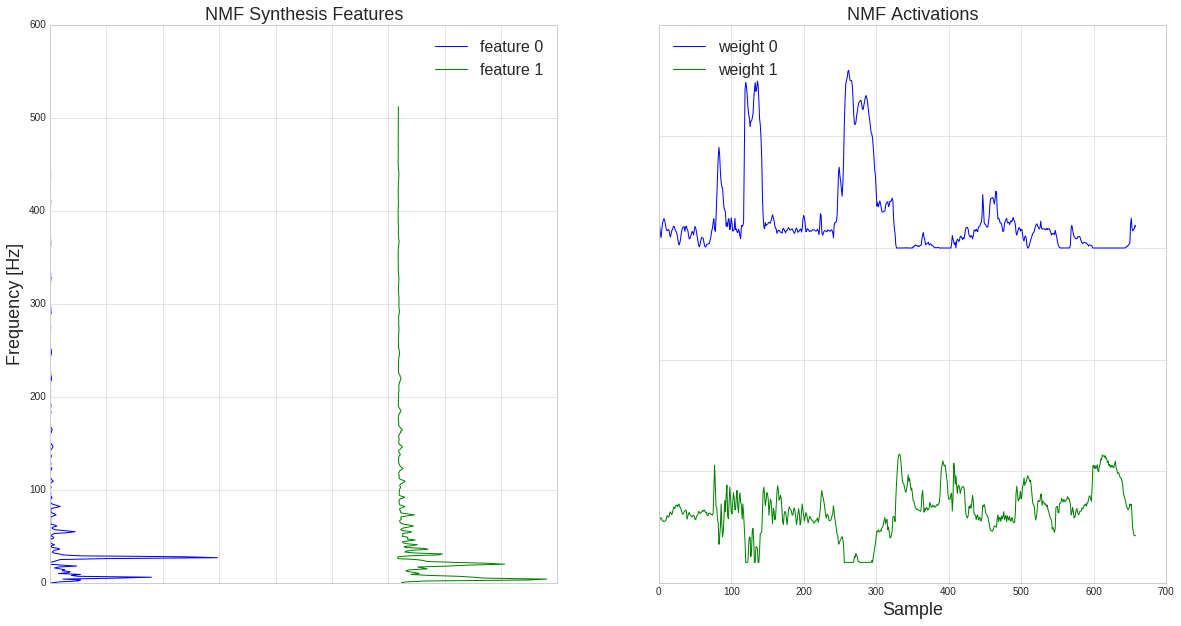

In [113]:
W_NMF, H_NMF = NMF(magnitude,k=num_components)
plot_NMF(W_NMF, H_NMF)

In [58]:
## Daniel trying STFT
# implementing links: https://dsp.stackexchange.com/questions/9877/reconstruction-of-audio-signal-from-spectrogram
# https://dsp.stackexchange.com/questions/3406/reconstruction-of-audio-signal-from-its-absolute-spectrogram/3410#3410
# https://dsp.stackexchange.com/questions/28569/recovering-phase-from-spectrogram
def mse(phase_pred, phase_true):
    '''
    Calculate the mean square error between the true phase and the
    predicted (reconstructed) phase.
    '''
    return np.mean(np.angle(phase_pred/phase_true)**2)


def get_comps(W, H, num_components):
    ret_list =  []
    for i in range(num_components):
        ret_list.append(W[:,i].reshape(-1, 1) @ H[i].reshape(1, -1))
    return ret_list

def save_comps(comps, phase):
    print(comps[0].shape)
    for i in range(2):
#         mag, actual_phase = librosa.magphase(comps[i])
        new_phase = np.exp(1.j * phase )#np.random.uniform(0., 2*np.pi, size=actual_phase.shape) * phase)
        x_ = librosa.istft(comps[i] * new_phase)
#         _, phase = librosa.magphase(librosa.stft(x_, window='hamming', n_fft=1024, hop_length=256))
#         x_ = librosa.istft(mag*actual_phase, hop_length=256)
        scipy.io.wavfile.write('comp{:05d}.wav'.format(i), sample_rate, x_)

# mag, actual_phase = librosa.magphase(D)
# # Try to reconstruct the phase using the iterative algorithm above.
# phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=actual_phase.shape))
# x_ = librosa.istft(mag * phase)
# print('iter {} mse {}'.format(-1, mse(phase, actual_phase)))
# for i in range(100+1):
#     _, phase = librosa.magphase(librosa.stft(x_, window='hamming', n_fft=1024))
#     x_ = librosa.istft(mag * phase)
#     print('iter {} mse {}'.format(i, mse(phase, actual_phase)))
#     if i % 10 == 0:
# scipy.io.wavfile.write('recons{:05d}.wav'.format(0), sample_rate, x_)

In [116]:
comps = get_comps(W_NMF, H_NMF, num_components)
print(comps[0].shape)
save_comps(comps, phase)

(513, 659)


In [40]:
class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [41]:
def time_freq_masking(M_stft, L_hat, S_hat, gain=3):
    mask = np.abs(S_hat) - gain * np.abs(L_hat)
    mask = (mask > 0) * 1
    X_sing = np.multiply(mask, M_stft)
    X_music = np.multiply(1 - mask, M_stft)
    return X_sing, X_music

In [74]:
rpca = R_pca(magnitude)

In [75]:
Lk, Sk = rpca.fit()
X_sing, X_music = time_freq_masking(magnitude, Lk, Sk, gain=2)

iteration: 1, error: 3477.1860506619423
iteration: 100, error: 0.12338564244054459
iteration: 124, error: 0.05509307292162461


In [76]:
save_comps([Lk, Sk], phase)

(513, 471)


In [22]:
from mir_eval.separation import bss_eval_sources 

In [27]:
mixed_wav = mixed
src1_orig, src2_orig = x[0,:], x[1,:]
print(src1_orig.shape)
print(X_sing.shape)

(168449,)
(513, 659)


In [36]:
new_phase = np.exp(1.j * phase)#np.random.uniform(0., 2*np.pi, size=actual_phase.shape) * phase)

pred_sing_wav = np.array(librosa.istft(X_sing*new_phase, hop_length=256))
pred_music_wav = np.array(librosa.istft(X_music*new_phase, hop_length=256))

In [37]:
len = pred_sing_wav.shape[0]
src1_wav = src1_orig[:len]
src2_wav = src2_orig[:len]
mixed_wav = mixed_wav[:len]
sdr, sir, sar, _ = bss_eval_sources(np.array([src1_wav, src2_wav]),
                                    np.array([pred_music_wav, pred_sing_wav]), compute_permutation=True)
sdr_mixed, _, _, _ = bss_eval_sources(np.array([src1_wav, src2_wav]),
                                      np.array([mixed_wav, mixed_wav]), compute_permutation=True)
# sdr, sir, sar, _ = bss_eval_sources(src2_wav,pred_src2_wav, False)
# sdr_mixed, _, _, _ = bss_eval_sources(src2_wav,mixed_wav, False)
nsdr = sdr - sdr_mixed

In [38]:
print(nsdr, sir, sar, len)

[12.5345437  12.57042131] [19.21292243 20.51137646] [13.64767093 13.38005209] 168448
